# Numerical Wasserstein Gradient Flow
This notebook provides both theoretical and computatinal overview of JKO scheme solving the gradient flow on Wasserstein space. Using existing implementations of the Chambolle-Pock (PDHG) method and Sinkhorn algorithm as a blackbox, we provide a solution to numerical Wasserstein Gradient Flow.

In [1]:
from src.jko_lab import * # access to solvers and utilities (PDHG, Sinkhorn)
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_hist_flow(
    mu_list,
    x,
    target=None,                 # optional target mass/density: same length as x
    interval=200,                # ms between frames
    title="Gradient Flow",
    xlabel="x",
    ylabel="Probability Density",
    bar_alpha=0.5,
    bar_edge="black",
    bar_color=None,              # None -> Matplotlib default
    line_color="red",
    ylim_pad=1.1,                # y-axis headroom factor
    return_html=True,            # return HTML string for display in notebooks
):
    """
    Animate a sequence of 1D measures as a bar 'histogram' over a fixed grid.

    Args
    ----
    mu_list : array-like, shape (T, n) or list of (n,)
        Sequence of measures (bin masses). Each frame will be normalized to sum=1.
    x : array-like, shape (n,)
        Bin centers (uniformly spaced).
    target : array-like, shape (n,), optional
        Target distribution. If supplied, it's plotted as a line (interpreted as mass; converted to density).
    interval : int
        Milliseconds between frames.
    title, xlabel, ylabel : str
        Labels.
    bar_alpha, bar_edge, bar_color : visual args for bars.
    line_color : color for the target curve.
    ylim_pad : float
        Multiplier for max y to add headroom.
    return_html : bool
        If True, return HTML string from ani.to_jshtml(); else return the Matplotlib Animation object.

    Returns
    -------
    HTML string (if return_html=True) or the Animation object.
    """
    # Convert to numpy (handles JAX arrays)
    mu_arr = np.asarray(mu_list)
    x = np.asarray(x)
    T, n = mu_arr.shape

    # Uniform bin width from centers
    if n < 2:
        raise ValueError("x must have at least 2 points to infer bin width.")
    bin_width = float(x[1] - x[0])

    # Densities for initial frame
    y0 = mu_arr[0] / np.sum(mu_arr[0])
    y0_density = y0 / bin_width

    # Optional target (mass or density -> convert to density)
    target_density = None
    if target is not None:
        tgt = np.asarray(target)
        if tgt.shape != (n,):
            raise ValueError("target must have shape (n,), same length as x.")
        # If target sums to ~1, treat as mass; otherwise assume it's already density
        if 0.9 <= float(np.sum(tgt)) <= 1.1:
            target_density = tgt / (np.sum(tgt) * bin_width)
        else:
            target_density = tgt

    # Figure/axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars at bin centers with width=bin_width
    bars = ax.bar(
        x, y0_density, width=bin_width, alpha=bar_alpha,
        align="center", edgecolor=bar_edge, color=bar_color, label="Distribution"
    )

    # Overlay target curve if provided
    if target_density is not None:
        (target_line,) = ax.plot(x, target_density, color=line_color, lw=2, label="Target Distribution")
    else:
        target_line = None

    # Axis limits
    y_max = y0_density.max()
    if target_density is not None:
        y_max = max(y_max, float(np.max(target_density)))
    ax.set_xlim(x.min() - 0.5 * bin_width, x.max() + 0.5 * bin_width)
    ax.set_ylim(0, y_max * ylim_pad)

    # Labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title} — step 0 / {T-1}")
    ax.legend()

    # Init function: zero bars (optional eye-candy)
    def init():
        for b in bars:
            b.set_height(0.0)
        return bars

    # Update per frame
    def animate(i):
        yi = mu_arr[i]
        yi = yi / np.sum(yi)            # normalize to probability mass 1
        yi_density = yi / bin_width      # convert to density
        for b, h in zip(bars, yi_density):
            b.set_height(float(h))
        ax.set_title(f"{title} — step {i} / {T-1}")
        return bars

    ani = animation.FuncAnimation(
        fig, animate, frames=np.arange(T), init_func=init,
        interval=interval, blit=True
    )
    plt.close(fig)  # avoid static figure in notebooks

    if return_html:
        return HTML(ani.to_jshtml())
    return ani

Let $X=\mathbb{R}^n$, $Y = \mathbb{R}^n$ with $n=10$. Consider a $n\times n$ Euclidean cost operator $C: \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}$ given by $C(x,y)=\vert x - y \vert^2$.

In [3]:
key = jax.random.PRNGKey(42)
n = 100

# 1D grid on [0,1]
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2  # squared Euclidean; the solver uses 0.5*C internally

Let the target marginal $\rho_k$ be a bimodal Gaussian distribution
$$
\rho_k = \frac{1}{2} \mathcal{N}(\mu=0.3,\sigma=0.05) + \frac{1}{2}\mathcal{N}(\mu=0.7,\sigma=0.05)
$$

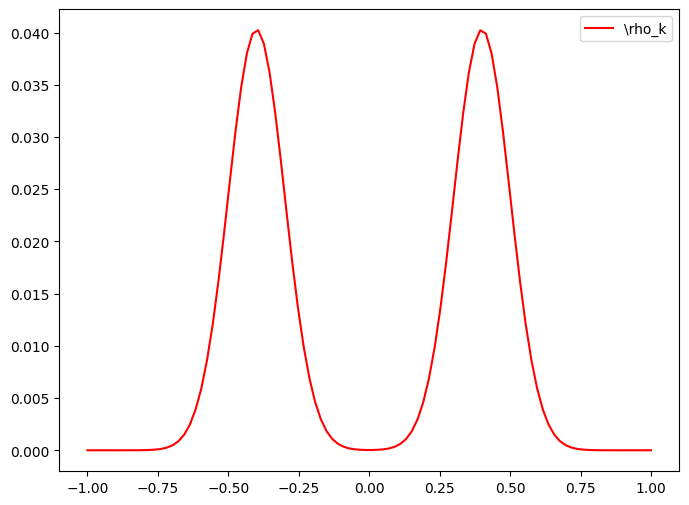

In [4]:
# Target marginal rho_k (right marginal), a bimodal distribution
rho_k = 0.5 * jax.scipy.stats.norm.pdf(x, 0.3, 0.05) + 0.5 * jax.scipy.stats.norm.pdf(x, 0.7, 0.05)
rho_k = jnp.clip(rho_k, 1e-12, None)
rho_k = rho_k / rho_k.sum()

COLORS = ["red", "green", "blue", "orange", "purple"]

def plot_vectors(n: int, data: dict):
    """
    Plots vectors supported on [-5,5] with respect to labels.
    """
    x = np.linspace(-1, 1, n)
    fig = plt.figure(figsize=(8, 6))
    i = 0
    for label, vec in data.items():
        plt.plot(x, vec, label=rf'\{label}', color=COLORS[i])
        i += 1
    plt.legend()

plot_vectors(n, {"rho_k":rho_k})

Given a probability vector $\rho \in \mathbb{R}^n$, let us choose the $F$-value entropy $F: \mathbb{R}^n \to \mathbb{R}$ as the classical Shannon entropy.
$$
F(\rho) = \sum_{i=1}^{n} \rho_i (\log \rho_i - 1)
$$

In [5]:
# Choose F = entropy (negative Boltzmann-Shannon)
def F_value_entropy(rho: jax.Array) -> jax.Array:
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe) - 1.0))

In [6]:
eta = 1e-2

# Run solver
state = pdhg_jko(
    C=C,
    rho_k=rho_k,
    eta=eta,
    proxF=proxF_entropy,        # prox_{alpha * Ent}
    proxF_kwargs=dict(eps=0.0),
    F_value=F_value_entropy,
    num_iters=500,
    tau=None,
    sigma=None,
    theta=1.0,
    pi0=None,
)

# Extract outputs
pi = state.pi
rho = state.rho
u = state.u
v = state.v

# Print basic info
# print("Final objective:", float(hist.primal_obj[-1]))
print("Column feasibility ||pi^T 1 - rho_k||:", float(jnp.linalg.norm(col_sums(pi) - rho_k)))
print("Mass check (should be 1):", float(rho.sum()))

TypeError: pdhg_jko() got an unexpected keyword argument 'F_value'

In [ ]:
 # Test: 2-point analytic trend
C2 = jnp.array([[0.0, 1.0], [1.0, 0.0]])
a = 0.2
rho_k2p = jnp.array([a, 1-a])
b1 = 0.8
b_vec = jnp.array([b1, 1-b1])

def prox_quad(z, alpha, b=b_vec, lam=1.0):
    return proxF_quadratic(z, alpha, b=b, lam=lam)

for e in [1e-5, 1e-3, 1e-1, 1e+1]:
    st = pdhg_jko(C=C2, rho_k=rho_k2p, eta=e, proxF=prox_quad, num_iters=4000)
    print(f"(2-pt) eta={e:.0e} -> rho0={float(st.rho[0]):.6f} (a={a}, b1={b1})")

In [ ]:
n = 32
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# Non-uniform initial distribution
rho0 = 0.75 * jax.scipy.stats.norm.pdf(x, 0.3, 0.05) + 0.25 * jax.scipy.stats.norm.pdf(x, 0.8, 0.03)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

b = jnp.ones_like(x) / n
lam = 1.0
def prox_quad(z, alpha, b=b, lam=lam):
    return proxF_quadratic(z, alpha, b=b, lam=lam)

rhos, feas = jko_flow(C, rho0, eta=1e-1, proxF=prox_quad, num_steps=50, inner_iters=1200)
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("[Flow-Quadratic] ||rho^k - b|| should decrease:")
for k in [0, 1, 5, 10, 20, 30, 50]:
    if k <= 50:
        print(f" k={k:2d}: ||rho-b||={float(dists[k]):.6f}")
print(" max column feasibility over steps:", float(jnp.max(feas)))

html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow (porous + V)"
)

html


In [ ]:
n = 64
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

rho0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

rhos, feas = jko_flow(C, rho0, eta=0.05, proxF=proxF_entropy, proxF_kwargs=dict(eps=0.0),
num_steps=30, inner_iters=1000)
b = jnp.ones_like(x)/n
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
Hs = jnp.array([entropy(r) for r in rhos])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 30]:
    if k <= 30:
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")
print(" max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
def proxF_relKL_to_b_safe(z, alpha, b, max_iter: int = 25):
    """
    Prox for F(x) = sum_i x_i (log(x_i/b_i) - 1).
    Returns prox_{alpha * F}(z) using Newton's method (per coordinate).
    Stable: no exp/lambertw; enforces x>0 by clamping each iteration.
    """
    b = jnp.clip(b, 1e-300, None)             # avoid log(0)
    alpha = jnp.asarray(alpha)

    def prox_one(z_i, b_i):
        # alpha==0 => identity
        def do_prox(_):
            # Good starting guess: max(z_i, eps)
            x0 = jnp.maximum(z_i, 1e-12)

            def step(x):
                # f(x) = x - z + alpha (log x - log b)
                f  = x - z_i + alpha * (jnp.log(x) - jnp.log(b_i))
                fp = 1.0 + alpha / x
                x_new = x - f / fp
                # enforce positivity and reasonable upper bound
                x_new = jnp.clip(x_new, 1e-30, 1e6)
                return x_new

            def body(_, x): return step(x)
            xT = lax.fori_loop(0, max_iter, body, x0)
            return xT

        return jnp.where(alpha > 0, do_prox(0), z_i)

    return jax.vmap(prox_one)(z, b)
#
# def proxF_rel_kl(z, alpha, b, eps=1e-18):
#     b = jnp.clip(b, eps, None)
#     arg = (b / alpha) * jnp.exp(z / alpha)
#     x = (alpha * lambertw(arg).real).astype(z.dtype)
#     return jnp.maximum(x, eps)

n = 600
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

rho0 = jax.scipy.stats.norm.pdf(x, 0.2, 0.05)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

# choose a non-uniform b (e.g., a smooth bump) -- limit should be b
b = jax.nn.softmax(-((x-0.6)**2)/0.02)
b = b / jnp.sum(b)


rhos, feas = jko_flow(C, rho0, eta=0.001,
                      proxF=lambda z, a: proxF_relKL_to_b_safe(z, a, b),
                      num_steps=600, inner_iters=5)

for k in [0, 1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 500, 600]:
    print(f"k={k:2d}: ||rho-b||={float(jnp.linalg.norm(rhos[k]-b)):.6f}")
print("max col feas:", float(jnp.max(feas)))

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow"
)

html

In [ ]:
def proxF_linear_potential(z: Array, alpha: float, c: Array, nonneg_eps: float = 0.0) -> Array:
    rho = z - alpha * c
    if nonneg_eps > 0:
        rho = jnp.maximum(rho, nonneg_eps)
    return rho

n = 100
x = jnp.linspace(-3.0, 3.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

x0 = 0.5 # target location
c = 0.5 * (x - x0) ** 2

rho0 = jax.scipy.stats.norm.pdf(x, -1.5, 0.5)
rho0 = jnp.clip(rho0, 1e-12, None)
rho0 = rho0 / rho0.sum()

rhos, feas = jko_flow(C, rho0, eta=0.5,
        proxF=lambda z, a: proxF_linear_potential(z, a, c, nonneg_eps=1e-20),
        num_steps=40, inner_iters=10000)

def variance(r):
    return float(jnp.sum(r * (x - x0) ** 2))
def mass_near(r, rad=0.15):
    return float(jnp.sum(r * (jnp.abs(x - x0) <= rad)))

print("[Flow-QuadraticPotential->Dirac] Expect Var↓, mass near x0↑:")
for k in [0, 1, 5, 10, 20, 40]:
    r = rhos[k]
    print(f" k={k:2d}: Var={variance(r):.6e}, mass(|x-x0|<=0.15)={mass_near(r):.6f}")
print(" max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=jnp.zeros_like(rhos[0]),                # or None
    interval=150,
    title="JKO Flow"
)

html

In [ ]:
def proxF_porous_media(z: Array, alpha: float, m: float, eps: float = 1e-18, newton_iters: int = 25) -> Array:
    """
    Prox for F(ρ) = (1/(m-1)) * sum ρ_i^m   with m > 1.
    Minimizes alpha*F(x) + 0.5||x - z||^2 (separable). Returns nonnegative solution.
    """
    z = jnp.asarray(z)

    if m == 2.0:
        # F = sum ρ^2  -> prox is linear
        return jnp.maximum(z / (1.0 + 2.0 * alpha), eps)

    c = alpha * (m / (m - 1.0))  # coefficient in the equation x + c * x^{m-1} = z

    def one(z_i):
        # Initial guess: positive and close to z_i
        x = jnp.maximum(z_i, eps)
        def step(x):
            f  = x + c * jnp.power(x, m - 1.0) - z_i
            fp = 1.0 + c * (m - 1.0) * jnp.power(x, m - 2.0)  # = 1 + alpha*m*x^{m-2}
            x_new = x - f / fp
            # keep it positive and bounded
            return jnp.clip(x_new, eps, 1e12)
        x = lax.fori_loop(0, newton_iters, lambda _, x: step(x), x)
        return x

    return jax.vmap(one)(z)

n = 300
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# Bimodal initial
rho0 = 0.6 * jax.scipy.stats.norm.pdf(x, 0.3, 0.04) + 0.4 * jax.scipy.stats.norm.pdf(x, 0.75, 0.05)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

m = 1.1  # try 1.5 or 3.0 as well
prox = lambda z, a: proxF_porous_media(z, a, m=m, eps=1e-18)

eta = 1e-2
rhos, feas = jko_flow(C, rho0, eta=eta, proxF=prox, num_steps=600, inner_iters=50)

b = jnp.ones_like(x) / n
def l2_to_uniform(r): return float(jnp.linalg.norm(r - b))
def rmax(r): return float(jnp.max(r))

print("[Flow-PorousMedia] toward uniform (expect ||rho-b|| ↓, max(rho) ↓):")
for k in [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={l2_to_uniform(r):.6f}, max(rho)={rmax(r):.6f} feasibility={feas[k]}")
print("  max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=jnp.zeros_like(rhos[0]),                # or None
    interval=150,
    title="JKO Flow"
)

html

In [ ]:
def proxF_chi2_to_b(z: Array, alpha: float, b: Array, eps: float = 1e-18) -> Array:
    """
    Prox for F(ρ) = sum (ρ_i^2 / b_i).
    Minimizes alpha * sum (x_i^2 / b_i) + 0.5 ||x - z||^2.
    Closed form per-coordinate: x = (b * z) / (b + 2*alpha).
    """
    b = jnp.clip(b, eps, None)
    x = (b * z) / (b + 2.0 * alpha)
    return jnp.maximum(x, eps)

n = 512
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# Initial
rho0 = jax.scipy.stats.norm.pdf(x, 0.1, 0.04)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

# Target b (non-uniform)
# b = 0.4 * jax.scipy.stats.norm.pdf(x, 0.6, 0.05) + 0.6 * jax.scipy.stats.norm.pdf(x, 0.4, 0.04)
# b = jnp.clip(b, 1e-18, None); b = b / b.sum()
b = jax.scipy.stats.cauchy.pdf(x, mu, sigma)
b = b / b.sum()

prox = lambda z, a: proxF_chi2_to_b(z, a, b=b, eps=1e-18)

eta = 1e-2
rhos, feas = jko_flow(C, rho0, eta=eta, proxF=prox, num_steps=600, inner_iters=50)

def dist(r): return float(jnp.linalg.norm(r - b))
print("[Flow-chi2->b] expect ||rho-b|| ↓:")
for k in [0, 1, 5, 10, 20, 40, 60, 80, 100]:
    print(f"  k={k:2d}: ||rho-b||={dist(rhos[k]):.6f} feas={feas[k]}")
print("  max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow"
)

html

In [ ]:
def proxF_porous_with_target(z: Array, alpha: float, m: float, b: Array, eps: float = 1e-18) -> Array:
    """
    Prox for F(ρ) = (1/(m-1)) * sum ρ_i^m  +  sum V_i ρ_i,  with V = -log b.
    Using: prox_{α(f + <V,·>)}(z) = prox_{α f}(z - α V).
    """
    b = jnp.clip(b, eps, None)
    V = b  # potential that makes b the Gibbs minimizer
    z_shifted = z - alpha * V
    return proxF_porous_media(z_shifted, alpha, m=m, eps=eps)

n = 128
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# Initial distribution: bimodal, non-uniform
rho0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.05) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.06)
rho0 = jnp.clip(rho0, 1e-18, None); rho0 = rho0 / rho0.sum()

# Target b: Gaussian (non-uniform)
mu, sigma = 0.6, 0.07
# b = jax.scipy.stats.norm.pdf(x, mu, sigma)
# b = jnp.clip(b, 1e-18, None); b = b / b.sum()

b = jax.scipy.stats.cauchy.pdf(x, mu, sigma)
b = b / b.sum()

# Prox for F = internal energy (m>1) + potential V=-log b
m = 1.5  # try 1.2, 1.5, 2.0 (all displacement-convex for m>=1)
prox = lambda z, a: proxF_porous_with_target(z, a, m=m, b=b, eps=1e-18)

# JKO flow params
eta = 1e-1
rhos, feas = jko_flow(C, rho0, eta=eta, proxF=prox, num_steps=600, inner_iters=50)

def dist_to_b(r): return float(jnp.linalg.norm(r - b))
def mass_near_center(r, rad=2*sigma):  # mass within ~2σ of mu
    return float(jnp.sum(r * (jnp.abs(x - mu) <= rad)))

print("[Flow-Porous+V(b)] toward Gaussian target b (expect ||rho-b|| ↓, mass near mu ↑):")
for k in [0, 1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 500, 600]:
    r = rhos[k]
    print(f"  k={k:2d}: ||rho-b||={dist_to_b(r):.6f}, mass(|x-mu|<=2σ)={mass_near_center(r):.6f}, feas={feas[k]:.6f}")
print("  max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow"
)

html

In [ ]:
rhos.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_hist_flow(
    mu_list,
    x,
    target=None,                 # optional target mass/density: same length as x
    interval=200,                # ms between frames
    title="Gradient Flow",
    xlabel="x",
    ylabel="Probability Density",
    bar_alpha=0.5,
    bar_edge="black",
    bar_color=None,              # None -> Matplotlib default
    line_color="red",
    ylim_pad=1.1,                # y-axis headroom factor
    return_html=True,            # return HTML string for display in notebooks
):
    """
    Animate a sequence of 1D measures as a bar 'histogram' over a fixed grid.

    Args
    ----
    mu_list : array-like, shape (T, n) or list of (n,)
        Sequence of measures (bin masses). Each frame will be normalized to sum=1.
    x : array-like, shape (n,)
        Bin centers (uniformly spaced).
    target : array-like, shape (n,), optional
        Target distribution. If supplied, it's plotted as a line (interpreted as mass; converted to density).
    interval : int
        Milliseconds between frames.
    title, xlabel, ylabel : str
        Labels.
    bar_alpha, bar_edge, bar_color : visual args for bars.
    line_color : color for the target curve.
    ylim_pad : float
        Multiplier for max y to add headroom.
    return_html : bool
        If True, return HTML string from ani.to_jshtml(); else return the Matplotlib Animation object.

    Returns
    -------
    HTML string (if return_html=True) or the Animation object.
    """
    # Convert to numpy (handles JAX arrays)
    mu_arr = np.asarray(mu_list)
    x = np.asarray(x)
    T, n = mu_arr.shape

    # Uniform bin width from centers
    if n < 2:
        raise ValueError("x must have at least 2 points to infer bin width.")
    bin_width = float(x[1] - x[0])

    # Densities for initial frame
    y0 = mu_arr[0] / np.sum(mu_arr[0])
    y0_density = y0 / bin_width

    # Optional target (mass or density -> convert to density)
    target_density = None
    if target is not None:
        tgt = np.asarray(target)
        if tgt.shape != (n,):
            raise ValueError("target must have shape (n,), same length as x.")
        # If target sums to ~1, treat as mass; otherwise assume it's already density
        if 0.9 <= float(np.sum(tgt)) <= 1.1:
            target_density = tgt / (np.sum(tgt) * bin_width)
        else:
            target_density = tgt

    # Figure/axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars at bin centers with width=bin_width
    bars = ax.bar(
        x, y0_density, width=bin_width, alpha=bar_alpha,
        align="center", edgecolor=bar_edge, color=bar_color, label="Distribution"
    )

    # Overlay target curve if provided
    if target_density is not None:
        (target_line,) = ax.plot(x, target_density, color=line_color, lw=2, label="Target Distribution")
    else:
        target_line = None

    # Axis limits
    y_max = y0_density.max()
    if target_density is not None:
        y_max = max(y_max, float(np.max(target_density)))
    ax.set_xlim(x.min() - 0.5 * bin_width, x.max() + 0.5 * bin_width)
    ax.set_ylim(0, y_max * ylim_pad)

    # Labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title} — step 0 / {T-1}")
    ax.legend()

    # Init function: zero bars (optional eye-candy)
    def init():
        for b in bars:
            b.set_height(0.0)
        return bars

    # Update per frame
    def animate(i):
        yi = mu_arr[i]
        yi = yi / np.sum(yi)            # normalize to probability mass 1
        yi_density = yi / bin_width      # convert to density
        for b, h in zip(bars, yi_density):
            b.set_height(float(h))
        ax.set_title(f"{title} — step {i} / {T-1}")
        return bars

    ani = animation.FuncAnimation(
        fig, animate, frames=np.arange(T), init_func=init,
        interval=interval, blit=True
    )
    plt.close(fig)  # avoid static figure in notebooks

    if return_html:
        return HTML(ani.to_jshtml())
    return ani

In [ ]:
html = animate_hist_flow(
    mu_list=rhos, x=np.asarray(x),
    target=b,                # or None
    interval=150,
    title="JKO Flow (porous + V)"
)

html